In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 把它转换成 tensor，映射到0到1之间的浮点数 因为一开始读进来可能是numpy的
# transforms.Normalize(mean, std) 表示将图像的每个通道（R、G、B）的像素值分别减去0.5并除以0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 每次测试或小批量训练的样本数为 4
batch_size = 4

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# shuffle=True表示在每个epoch训练之前对数据进行洗牌 num_workers=2表示使用2个子进程来加载数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import torch.nn as nn
class SEBlock(nn.Module):
    def __init__(self, in_channel, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.se_avgpool = nn.AdaptiveAvgPool2d(1)
        self.se_relu = nn.ReLU()
        self.se_fc1 = nn.Linear(in_channel, in_channel // reduction_ratio)
        self.se_fc2 = nn.Linear(in_channel // reduction_ratio, in_channel)

    def forward(self, x):
        batch, channel, height, width = x.size()
        out = self.se_avgpool(x).view(batch, channel)
        # print(f"    @SEBlock after se_avg_pool {out.shape}")
        out = self.se_fc1(out)
        # print(f"    @SEBlock after se_fc1 {out.shape}")
        out = self.se_relu(out)
        out = torch.sigmoid(self.se_fc2(out))
        # print(f"    @SEBlock after se_fc2 {out.shape}")
        out = out.view(batch, channel, 1, 1)
        final_out = x * out
        # print(f"    @SEBlock final_out {final_out.shape}")
        return final_out


class Downsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=2, padding=0)
        self.bn = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class BasicBlock(nn.Module):
    """
    ResNet-18、ResNet-34
    """
    def __init__(self, in_channel, out_channel, stride=1, flag=False):
        """
        :param flag: 下采样
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        # conv2的 in_channels 应该是 out_channel！！
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.seblock = SEBlock(out_channel)
        # self.downsample = None
        # 下采样方法
        self.flag = flag
        self.downsample = None
        if self.flag is True:
            self.downsample = Downsample(in_channel, out_channel)

    # def my_downsample(self, x, d_in_channel, d_out_channel):
    #     self.ds_conv = nn.Conv2d(d_in_channel, d_out_channel, kernel_size=(1, 1), stride=(2, 2), padding=0)
    #     self.ds_batch_normal = nn.BatchNorm2d(d_out_channel)

    def forward(self, x):
        # shortcut分支
        identity = x
        if self.flag is True:
            identity = self.downsample(x)
        # res block
        out = self.conv1(x)

        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # add SEblock
        out = self.seblock(out)

        out += identity
        out = self.relu(out)
        return out

class SEResNet(nn.Module):
    """
    SE-resnet
    """
    def __init__(self, block_num=1, num_classes=10):
        super(SEResNet, self).__init__()
        # 输入特征矩阵的深度
        # self.in_channel = 64

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1,
                               padding=3, bias=False)

        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # resnet
        self.layer1 = BasicBlock(32, 32, 1)
        self.layer2 = BasicBlock(32, 64, 2, True)
        self.layer3 = BasicBlock(64, 64, 1)
        self.layer4 = BasicBlock(64, 128, 2, True)

        #self.fc1 = nn.Linear(, num_classes)
        self.fc1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        # print("Input shape:", x.shape)
        x = self.conv1(x)
        # print("After conv1 shape:", x.shape)
        x = self.bn1(x)
        #print("After bn1 shape:", x.shape)
        x = self.relu1(x)
        #print("After relu shape:", x.shape)
        x = self.maxpool(x)
        # print("After maxpool shape:", x.shape)

        x = self.layer1(x)
        # print("After layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("After layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("After layer3 shape:", x.shape)
        x = self.layer4(x)
        # print("After layer4 shape:", x.shape)
        #x = self.fc1(x)
        #print("After fc1 shape:", x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # print("After fc1 shape:", x.shape)
        #print("After flatten shape:", x.shape)
        return x


In [11]:
def test():
    net = SEResNet()
    # 输入数据
    input_data = torch.randn(1, 3, 32, 32)

    # 前向传播
    output = net(input_data)
    print(net)

In [12]:
test()

SEResNet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (seblock): SEBlock(
      (se_avgpool): AdaptiveAvgPool2d(output_size=1)
      (se_relu): ReLU()
      (se_fc1): Linear(in_features=32, out_features=2, bias=True)
      (se_fc2): Linear(in_features=2, out_features=32, bias=True)
    )
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(3

In [13]:
net = SEResNet()
import torch.optim as optim
# 定义损失函数，交叉熵损失
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
# 单个 epoch 的训练过程
def train(epoch):
    # Set model to training mode
    # 训练模式
    net.train()
    
    running_loss = 0.0
    correct = 0 # 正确预测的图片
    total = 0 # 总数
    cur_loss = 0
    
    # Loop over each batch from the training set
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 对损失函数进行反向传播
        loss.backward()
        # Update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        cur_loss += loss.item()
#         # 计算每轮预测正确的图片及图片总数
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
                
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'Train Epoch:{epoch }  [{i - 1999:5d}, {i + 1:5d}] loss: {running_loss / 2000:.3f} accuracy:{correct / total * 100}')      
            running_loss = 0.0

In [15]:
# 用于在验证集上评估训练好的模型的性能
def validate(loss_vector, accuracy_vector):
    # 将模型设置为评估模式
    net.eval()
    val_loss, correct = 0, 0
    # 循环
    for data, target in testloader:
#         data = data.to(device)
#         target = target.to(device)
        output = net(data)
    
        # 损失累加到 val_loss 变量中
        val_loss += criterion(output, target).data.item()
        # 预测
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    # 在循环结束后，计算整个验证集上的平均损失，并将其附加到 loss_vector 列表中。
    # 计算模型在整个验证集上的精度，并将其附加到 accuracy_vector 列表中。
    # 函数最后会打印出平均损失和精度。
    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))

In [16]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch:1  [    0,  2000] loss: 1.852 accuracy:35.05
Train Epoch:1  [ 2000,  4000] loss: 1.510 accuracy:40.71875
Train Epoch:1  [ 4000,  6000] loss: 1.359 accuracy:44.46666666666667
Train Epoch:1  [ 6000,  8000] loss: 1.265 accuracy:47.081250000000004
Train Epoch:1  [ 8000, 10000] loss: 1.185 accuracy:49.3925
Train Epoch:1  [10000, 12000] loss: 1.143 accuracy:51.108333333333334

Validation set: Average loss: 1.1353, Accuracy: 5997/10000 (60%)

Train Epoch:2  [    0,  2000] loss: 1.002 accuracy:64.5625
Train Epoch:2  [ 2000,  4000] loss: 0.970 accuracy:65.375
Train Epoch:2  [ 4000,  6000] loss: 0.980 accuracy:65.41666666666667
Train Epoch:2  [ 6000,  8000] loss: 0.941 accuracy:65.746875
Train Epoch:2  [ 8000, 10000] loss: 0.918 accuracy:66.0825
Train Epoch:2  [10000, 12000] loss: 0.923 accuracy:66.38958333333333

Validation set: Average loss: 0.8615, Accuracy: 6930/10000 (69%)

Train Epoch:3  [    0,  2000] loss: 0.787 accuracy:72.7125
Train Epoch:3  [ 2000,  4000] loss: 0.793 accur

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation accuracy')

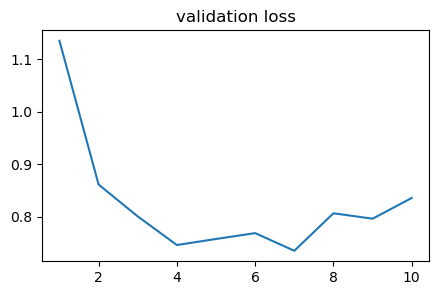

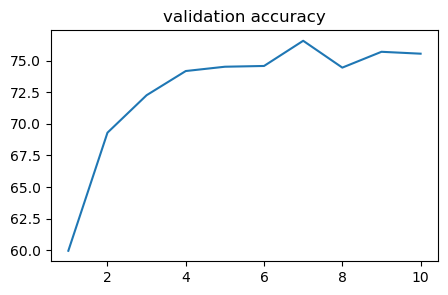

In [17]:
# 损失
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
# 准确率
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')